In [1]:
from utils.loss_functions import DKDLoss
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_package.models import Teacher, Student
from torchvision import datasets, transforms, models
import models_package
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# new libraries
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof
import boto3
import io
from utils.compare_tools import compare_model_size, compare_inference_time, compare_performance_metrics, plot_comparison
from utils.misc_tools import best_LR, train_teacher, retrieve_teacher_class_weights, new_teacher_class_weights

## Find best LR

In [2]:
# Hyperparameters
learning_rate = 0.01  # 0.01 for resnet34x2 & 0.1 for resnet8 & 0.003 for resnet 8x4
num_epochs =  2 # 200
num_workers = 2
batch_size = 128
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 10
step_size = 30
gamma = 0.1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
weight_decay_input = 5e-4
# epochs = 20
# T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping

## Load in Data

In [3]:
# Load IdenProf dataset
train_path = '/home/ubuntu/W210-Capstone/notebooks/idenprof/train'
test_path = '/home/ubuntu/W210-Capstone/notebooks/idenprof/test'
batch_size = 8
trainloader, testloader  = load_prof(train_path, test_path, batch_size=batch_size)

## Load in models

### resnet32x4_idenprof

In [4]:
# Instantiate the models

# Create instances of your models
# teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
# teacher_model.eval()  # Set teacher model to evaluation mode
# student_model = torchvision.models.resnet18(weights=None).cuda()

# teacher_name = 'resnet32x4_idenprof'
# teacher_model = models_package.__dict__[teacher_name](num_class=10)
# teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 10)

In [5]:
# teacher_model

### resnet8_idenprof

In [6]:
# teacher_name = 'resnet8_idenprof'
# teacher_model = models_package.__dict__[teacher_name](num_class=10)
# teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 10)

### resnet8x4_idenprof

In [7]:
# student_name = 'resnet8x4_idenprof'
# student_model = models_package.__dict__[student_name](num_class=10)
# student_model.fc = nn.Linear(student_model.fc.in_features, 10)

### shufflenet-v1

In [4]:
from models_package import shufflenetv1_idenprof

num_class = 10
student_model = shufflenetv1_idenprof.shufflev1_idenprof(num_class=num_class)
student_model.fc = nn.Linear(student_model.fc.in_features, 10)

In [9]:
# # Instantiate the model
# num_class = 10
# student_model = shufflenetv1_idenprof.shufflev1_idenprof(num_class=num_class)

# dummy_input = torch.randn(1, 3, 32, 32)
# dummy_output = student_model(dummy_input, embed=False)
# dummy_output

In [10]:
# # Optimizer and scheduler for the teacher model
# teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
# teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)


criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Best LR

In [11]:
# teacher_lr = best_LR('resnet32x4_lr', teacher_model, trainloader, 
#                      criterion, teacher_optimizer, 
#                      teacher_scheduler, num_epochs=3, emb = True)
# teacher_lr

In [12]:
# student_lr = best_LR('resnet8x4_lr', student_model, trainloader,
#                      criterion, student_optimizer, student_scheduler, 
#                      num_epochs=3, emb = True)
# student_lr

100%|████████████████████████████████████████████████████| 1125/1125 [02:12<00:00,  8.48it/s]


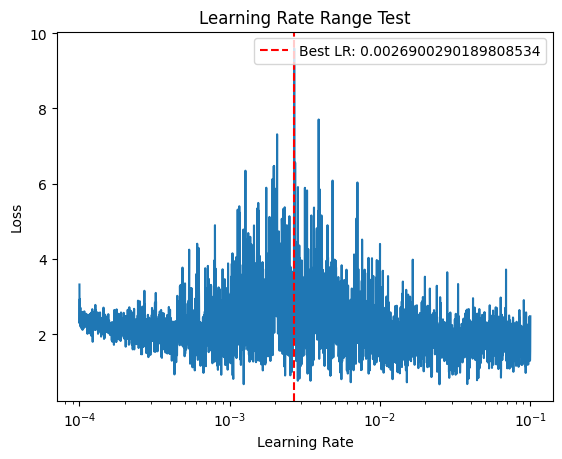

Best learning rate: 0.0026900290189808534


0.0026900290189808534

In [13]:
student_lr = best_LR('shufflenet_v1', student_model, trainloader,
                     criterion, student_optimizer, student_scheduler, 
                     num_epochs=3, emb = True)
student_lr

In [5]:
# teacher_lr = 0.00036685719526150065
student_lr = 0.00269

In [6]:
# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=student_lr, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# # Optimizer and scheduler for the teacher model
# teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=teacher_lr, momentum=momentum)
# teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Train Leaderboard Teacher Models

In [14]:
# teacher_resnet32x4 = \
#     train_teacher('resnet_32x4', teacher_model, trainloader, criterion, 
#                   teacher_optimizer, teacher_scheduler, 
#                   num_epochs=260, patience=5)

In [7]:
student_shufflenetv1 = \
    train_teacher('shufflenet_v1', student_model, trainloader,
                  criterion, student_optimizer, student_scheduler, 
                  num_epochs=1, patience=5)


  9%|████▊                                                | 101/1125 [00:12<02:00,  8.50it/s]

[1, 100] loss: 4.226


 18%|█████████▍                                           | 201/1125 [00:24<01:48,  8.48it/s]

[1, 200] loss: 3.169


 27%|██████████████▏                                      | 301/1125 [00:35<01:36,  8.50it/s]

[1, 300] loss: 2.747


 36%|██████████████████▉                                  | 401/1125 [00:47<01:25,  8.50it/s]

[1, 400] loss: 3.000


 45%|███████████████████████▌                             | 501/1125 [00:59<01:13,  8.51it/s]

[1, 500] loss: 2.554


 53%|████████████████████████████▎                        | 601/1125 [01:11<01:01,  8.50it/s]

[1, 600] loss: 2.207


 62%|█████████████████████████████████                    | 701/1125 [01:22<00:49,  8.51it/s]

[1, 700] loss: 2.238


 71%|█████████████████████████████████████▋               | 801/1125 [01:34<00:38,  8.48it/s]

[1, 800] loss: 1.998


 80%|██████████████████████████████████████████▍          | 901/1125 [01:46<00:26,  8.51it/s]

[1, 900] loss: 1.930


 89%|██████████████████████████████████████████████▎     | 1001/1125 [01:58<00:14,  8.51it/s]

[1, 1000] loss: 1.922


 98%|██████████████████████████████████████████████████▉ | 1101/1125 [02:09<00:02,  8.50it/s]

[1, 1100] loss: 1.829


100%|████████████████████████████████████████████████████| 1125/1125 [02:12<00:00,  8.48it/s]

Finished Training Teacher


## Extract Class Weights for Norm and Direction

In [8]:
## Load in model and weights
model_path = './weights/resnet_32x4/checkpoint.pth'
weights_path = './weights/resnet_32x4/weights.pth'
test_path = './weights/resnet_32x4/test.pth'
# idenprof_resnet32x4_model = torch.load(weights_path)
# # idenprof_resnet32x4_model.load_state_dict(torch.load(weights_path))
# # idenprof_resnet32x4_model.eval()
# # idenprof_resnet32x4_model.items()

# # import torch, torchvision.models
# # model = torchvision.models.vgg16()
# # path = 'test.pth'
# torch.save(idenprof_resnet32x4_model.state_dict(), test_path) # nothing else here
# idenprof_resnet32x4_model.load_state_dict(torch.load(test_path))

In [9]:
model_name = 'resnet32x4_idenprof'
num_class = 10
model = models_package.__dict__[model_name](num_class=num_class)
checkpoint = torch.load(weights_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KeyError: 'model_state_dict'

In [16]:
print(idenprof_resnet32x4_model)

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [5]:
def retrieve_teacher_class_weights(model_name, model_weight_path, num_class, data_name, dataloader, batch_size):
    ''' Use the extracted feature embeddings to create a json of class means for teacher'''
    model = models_package.__dict__[model_name](num_class=num_class)
    model_ckpt = models_package.__dict__[model_name](num_class=num_class)
    print('Visualized the embedding feature of the {} model on the train set'.format(model_name))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_ckpt.to(device)
    model_ckpt.load_state_dict(torch.load(model_weight_path))
    model_ckpt.eval()
    new_state_dict = OrderedDict()
    for k, v in model_ckpt.items():
        name = k[7:]   # remove 'module.'
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)

    for param in model.parameters():
        param.requires_grad = False
    
    model = model.cuda()

    emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    emb_json = json.dumps(emb, indent=4)
    with open("./class_means/{}_embedding_fea/{}.json".format(data_name, model_name), 'w', encoding='utf-8') as f:
        f.write(emb_json)
    f.close()

In [6]:
retrieve_teacher_class_weights(model_name = 'resnet32x4_idenprof', 
                               model_weight_path = './weights/resnet_32x4/weights.pth', 
                               num_class = 10, 
                               data_name = 'idenprof',
                               dataloader = trainloader, 
                               batch_size = 128
                              )


Visualized the embedding feature of the resnet32x4_idenprof model on the train set


AttributeError: 'ResNet' object has no attribute 'items'

In [4]:
new_teacher_class_weights(model_name = 'resnet32x4_idenprof', 
                               model_weight_path = './weights/resnet_32x4/weights.pth', 
                               num_class = 10, 
                               data_name = 'idenprof',
                               dataloader = trainloader, 
                               batch_size = 128
                              )


Visualized the embedding feature of the resnet32x4_idenprof model on the train set


KeyError: 'model_state_dict'

## Train Leaderboard Student Models

In [ ]:
########## Need studnet model loss function

In [ ]:
# Studnet Model Training

## Save Models and Weights

In [ ]:
## backup
# Save the student and teacher model weights and architecture
torch.save(teacher_model.state_dict(), 'teacher_model_weights_resnet8_4.pth')
torch.save(teacher_model, 'testing_teacher_model_resnet8_4.pth')
print('student weights and architecture saved and exported')

In [ ]:
###################### Saving weights and movel using s3 bucket ######################

session = boto3.session.Session()
s3 = session.client('s3')

bucket_name = '210bucket' 

# Teacher Model
#### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
teacher_model_weights_path = 'weights/teacher_model_weights_resnet8_4.pth'
teacher_model_path = 'models/testing_teacher_model_resnet8_4.pth'

# Save state dict to buffer
teacher_model_weights_buffer = io.BytesIO()
torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
teacher_model_weights_buffer.seek(0)

# Save entire model to buffer
teacher_model_buffer = io.BytesIO()
torch.save(teacher_model, teacher_model_buffer)
teacher_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
print('teacher weights and architecture saved and exported to S3')

# # Student Model
# #### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
# student_model_weights_path = 'weights/student_model_weights.pth' 
# student_model_path = 'models/student_model.pth'

# # Save state dict to buffer
# student_model_weights_buffer = io.BytesIO()
# torch.save(student_model.state_dict(), student_model_weights_buffer)
# student_model_weights_buffer.seek(0)

# # Save entire model to buffer
# student_model_buffer = io.BytesIO()
# torch.save(student_model, student_model_buffer)
# student_model_buffer.seek(0)

# # Upload to S3
# s3.put_object(Bucket=bucket_name, Key=student_model_weights_path, Body=student_model_weights_buffer)
# s3.put_object(Bucket=bucket_name, Key=student_model_path, Body=student_model_buffer)
# print('student weights and architecture saved and exported to S3')

## Read Models and Weights

In [6]:
# Initialize a session using Boto3 again 
session = boto3.session.Session()

s3 = session.client('s3')
bucket_name = '210bucket'  

teacher_model_weights_s3_path = 'weights/idenprof_teacher_resnet32x4_weights.pth'
# student_model_weights_s3_path = 'weights/testing_student_model_weights_rkd_prof.pth'

# Read files directly into memory
teacher_model_weights_buffer = io.BytesIO()
# student_model_weights_buffer = io.BytesIO()

s3.download_fileobj(bucket_name, teacher_model_weights_s3_path, teacher_model_weights_buffer)
# s3.download_fileobj(bucket_name, student_model_weights_s3_path, student_model_weights_buffer)

# Load the weights into the models
teacher_model_weights_buffer.seek(0)  # Move to the beginning of the buffer
# student_model_weights_buffer.seek(0)  

######## MAKE SURE THAT YOU HAVE THE CORRECT MODELS FOR WEIGHTS ########
# Teacher
# teacher_name = 'resnet8x4_idenprof'
teacher_name = 'resnet32x4_idenprof'
teacher_model = models_package.__dict__[teacher_name](num_class=10)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 10)
teacher_model.load_state_dict(torch.load(teacher_model_weights_buffer))
teacher_model.eval()
# # Student
# student_model = CustomResNet18()
# student_model.load_state_dict(torch.load(student_model_weights_buffer))


ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [13]:
import boto3
import io
import os
import torch
import torch.nn as nn
from collections import OrderedDict
import json
import models_package  
import numpy as np


# # Function definitions


#### without mean
# def get_emb_fea(model, dataloader, batch_size):
#     # Define the device
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model.to(device)
#     model.eval() 
#     embeddings = []

#     with torch.no_grad(): 
#         for data in dataloader:
#             inputs, labels = data
#             inputs = inputs.to(device)

#             output = model(inputs)
#             if isinstance(output, tuple):
#                 output = output[0]

#             embeddings.append(output.cpu().numpy())

#     embeddings = np.concatenate(embeddings, axis=0).tolist() 
#     return embeddings


#### with mean
def get_emb_fea(model, dataloader, batch_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval() 
    class_embeddings = {}

    with torch.no_grad(): 
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.cpu().numpy()

            output = model(inputs)
            if isinstance(output, tuple):
                output = output[0]

            embeddings = output.cpu().numpy()

            for emb, label in zip(embeddings, labels):
                label = int(label)  
                if label not in class_embeddings:
                    class_embeddings[label] = []
                class_embeddings[label].append(emb)

    class_mean_embeddings = {label: np.mean(np.array(embs), axis=0).tolist() 
                             for label, embs in class_embeddings.items()}

    return class_mean_embeddings


#### the original function with a small update
# def get_emb_fea(model, dataloader, batch_size):
#     ''' Used to extract the feature embeddings in a teacher model '''
#     model.eval()

#     EMB = {}

#     with torch.no_grad():
#         for images, labels in dataloader:
#             images, labels = images.cuda(), labels.cuda()

#             # compute output
#             emb_fea, logits = model(images, embed=True)

#             for emb, i in zip(emb_fea, labels):
#                 i = i.item()
#                 emb_size = len(emb) 
#                 if str(i) in EMB:
#                     for j in range(emb_size):
#                         EMB[str(i)][j].append(round(emb[j].item(), 4))
#                 else:
#                     EMB[str(i)] = [[] for _ in range(emb_size)]
#                     for j in range(emb_size):
#                         EMB[str(i)][j].append(round(emb[j].item(), 4))

#     for key, value in EMB.items():
#         for i in range(emb_size):
#             EMB[key][i] = round(np.array(EMB[key][i]).mean(), 4)

#     return EMB

    

def retrieve_teacher_class_weights(model_name, model_weight_path, num_class, data_name, dataloader, batch_size, bucket_name):
    ''' Use the extracted feature embeddings to create a json of class means for teacher'''

    session = boto3.session.Session()
    s3 = session.client('s3')

    teacher_model_weights_buffer = io.BytesIO()
    s3.download_fileobj(bucket_name, model_weight_path, teacher_model_weights_buffer)
    teacher_model_weights_buffer.seek(0)  

    # Load the model
    model = models_package.__dict__[model_name](num_class=num_class)
    checkpoint = torch.load(teacher_model_weights_buffer)
    print("Keys in checkpoint:", checkpoint.keys())

    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        name = k[7:] if k.startswith('module.') else k
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    model.eval()

    for param in model.parameters():
        param.requires_grad = False
    
    model = model.cuda()

    # emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    # emb_json = json.dumps(emb, indent=4)
    # with open("./class_means/{}_embedding_fea/{}.json".format(data_name, model_name), 'w', encoding='utf-8') as f:
    #     f.write(emb_json)

    emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    emb_json = json.dumps(emb, indent=4)

    # Create the directory if it doesn't exist
    output_dir = "./class_means/{}_embedding_fea".format(data_name)
    os.makedirs(output_dir, exist_ok=True)

    with open("{}/{}.json".format(output_dir, model_name), 'w', encoding='utf-8') as f:
        f.write(emb_json)

# Calling the function
model_name = 'resnet32x4_idenprof'
model_weight_path = 'weights/idenprof_teacher_resnet32x4_weights.pth'
num_class = 10
data_name = 'idenprof'  
batch_size = 0  
bucket_name = '210bucket'  

retrieve_teacher_class_weights(model_name, model_weight_path, num_class, data_name, testloader, batch_size, bucket_name)


Keys in checkpoint: odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked'

## LB Help

1. loading in model weights and idenprof dataset from s3 (LB will set up) __COMPLETE__
2. save model weights to s3 bucket (moving forward) __COMPLETE__
3. Teachers: help running resnet-34x2 (LB) -- needs to be trained on idenprof __COMPLETE__
4. Make sure that resnet-8x4 is running __COMPLETE__
5. Student: shufflenet-v1  -- just need to make them run